Loading and cleaning data...


/var/folders/82/n2wrm9914vn4m3chfl1g9pd80000gn/T/ipykernel_2943/1809872202.py:9: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('../data/household_power_consumption.txt', sep=';',
/var/folders/82/n2wrm9914vn4m3chfl1g9pd80000gn/T/ipykernel_2943/1809872202.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('../data/household_power_consumption.txt', sep=';',
/var/folders/82/n2wrm9914vn4m3chfl1g9pd80000gn/T/ipykernel_2943/1809872202.py:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_cs

Data ready.
Running Advanced SQL Queries...
         day  daily_avg  daily_peak  moving_avg_7d  change_vs_yesterday
0 2006-12-16   3.053475       7.706       3.053475                  NaN
1 2006-12-17   2.354486       7.064       2.703980            -0.698989
2 2006-12-18   1.530435       6.158       2.312799            -0.824051
3 2006-12-19   1.157079       7.840       2.023869            -0.373356
4 2006-12-20   1.545658       5.988       1.928227             0.388579
5 2006-12-21   1.193758       5.854       1.805815            -0.351900
6 2006-12-22   1.625929       7.884       1.780117             0.432171
7 2006-12-23   3.314851       8.698       1.817457             1.688922
8 2006-12-24   1.770842       6.824       1.734079            -1.544010
9 2006-12-25   1.904944       6.702       1.787580             0.134103


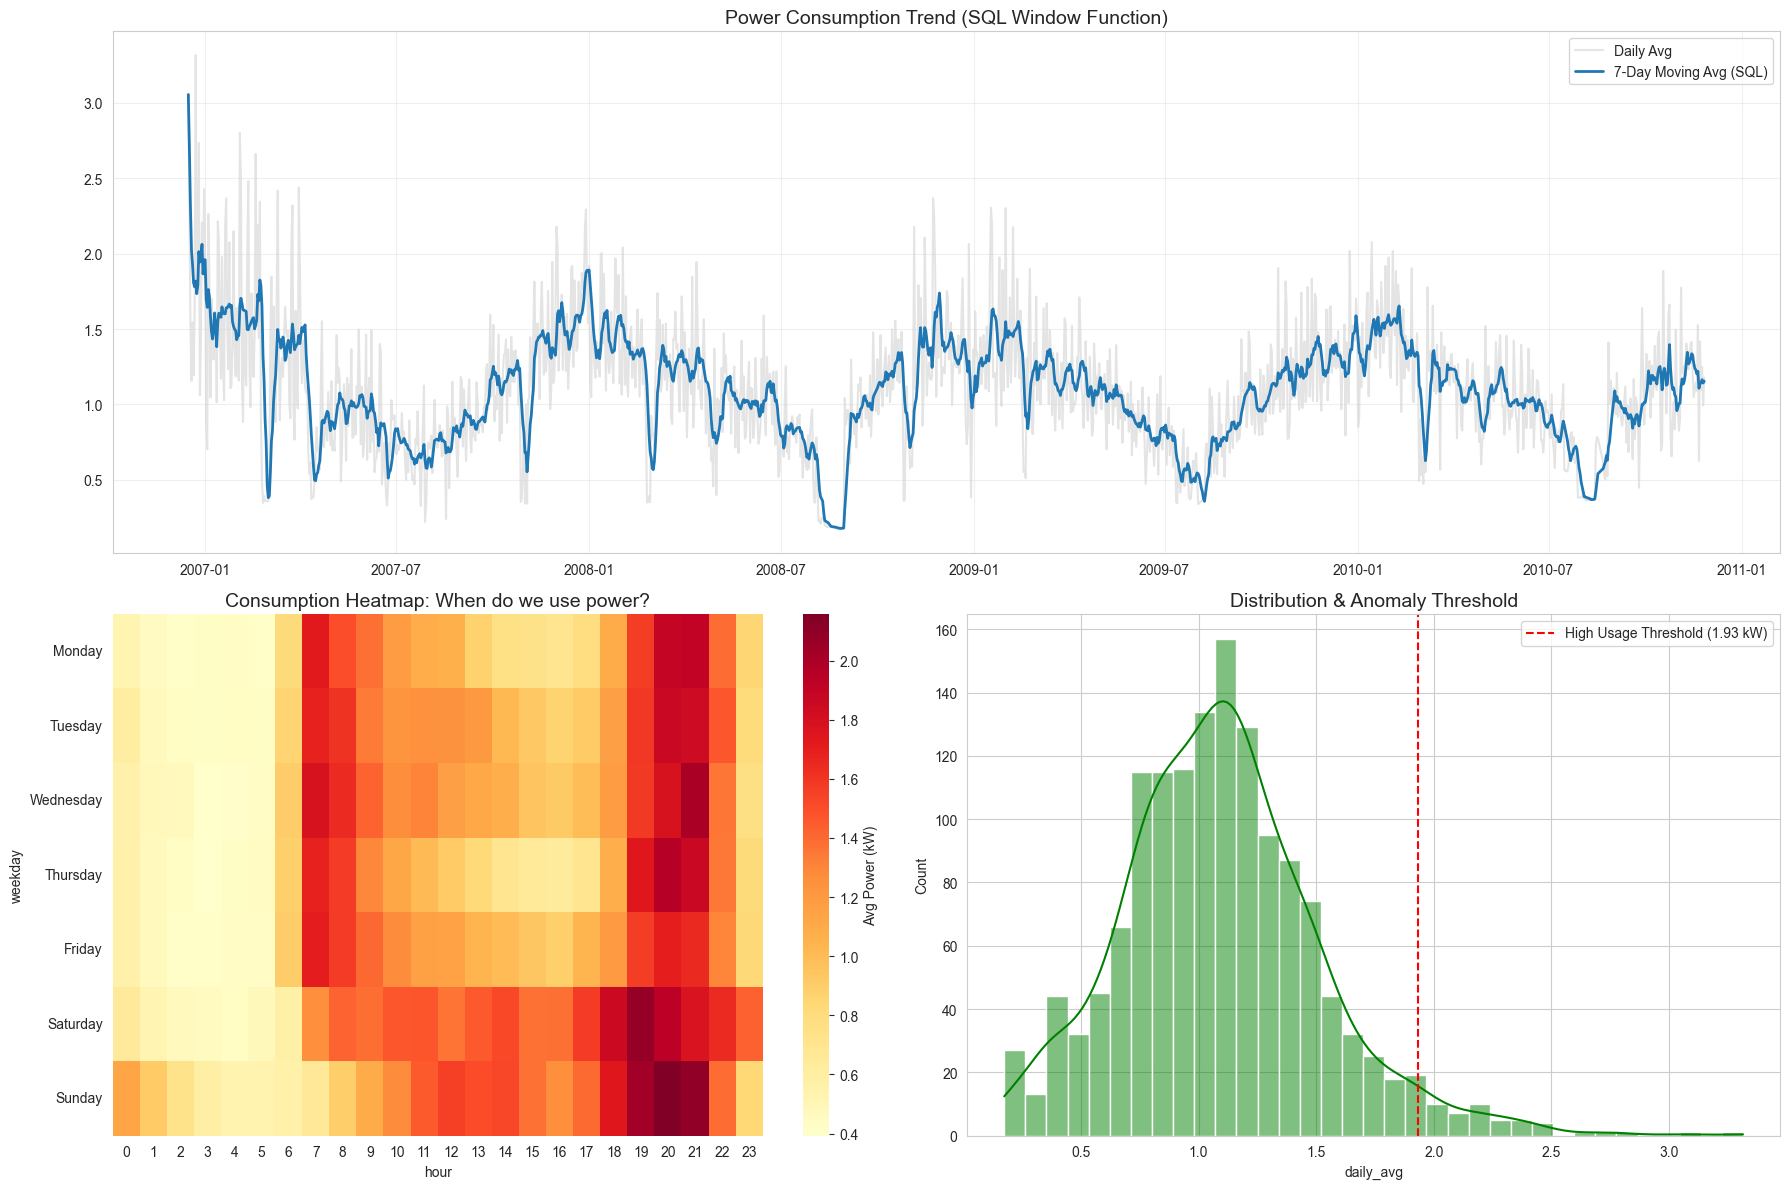


--- BUSINESS REPORT ---
Total days analyzed: 1433
Identified 51 days with anomalous high consumption.
Recommendation: Investigate HVAC usage or insulation on these peak dates.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# --- STEP 1: LOAD & ADVANCED CLEANING ---
print("Loading and cleaning data...")
df = pd.read_csv('../data/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt': ['Date', 'Time']}, 
                 infer_datetime_format=True, 
                 low_memory=False, 
                 na_values=['nan','?'])

# Convert to numeric
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in cols:
    df[col] = pd.to_numeric(df[col])

df.dropna(inplace=True)

# Add Feature Engineering (Hour, Weekday) for Heatmap later
df['hour'] = df['dt'].dt.hour
df['weekday'] = df['dt'].dt.day_name()
print("Data ready.")

# --- STEP 2: ADVANCED SQL (Window Functions) ---
# This proves to 1KOMMA5°/ista that you know complex SQL
conn = sqlite3.connect(':memory:')
df.to_sql('smart_meter', conn, index=False, if_exists='replace')

print("Running Advanced SQL Queries...")

query_advanced = """
WITH DailyStats AS (
    SELECT 
        date(dt) as day,
        AVG(Global_active_power) as daily_avg,
        MAX(Global_active_power) as daily_peak
    FROM smart_meter
    GROUP BY date(dt)
)
SELECT 
    day,
    daily_avg,
    daily_peak,
    -- WINDOW FUNCTION: 7-Day Moving Average calculated in SQL
    AVG(daily_avg) OVER (
        ORDER BY day 
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ) as moving_avg_7d,
    -- LAG FUNCTION: Compare with previous day
    daily_avg - LAG(daily_avg, 1) OVER (ORDER BY day) as change_vs_yesterday
FROM DailyStats
ORDER BY day
"""

df_sql = pd.read_sql_query(query_advanced, conn)
df_sql['day'] = pd.to_datetime(df_sql['day'])
print(df_sql.head(10))

# --- STEP 3: VISUALIZATION (Dashboard Style) ---
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2)

# Plot 1: Trend & Moving Average (from SQL)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df_sql['day'], df_sql['daily_avg'], color='lightgray', label='Daily Avg', alpha=0.6)
ax1.plot(df_sql['day'], df_sql['moving_avg_7d'], color='#1f77b4', linewidth=2, label='7-Day Moving Avg (SQL)')
ax1.set_title('Power Consumption Trend (SQL Window Function)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Consumption Heatmap (Hour vs Weekday) - Very popular in Energy Analytics!
ax2 = fig.add_subplot(gs[1, 0])
# Aggregate for heatmap
pivot_table = df.pivot_table(values='Global_active_power', index='weekday', columns='hour', aggfunc='mean')
# Sort days correctly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(days_order)
sns.heatmap(pivot_table, cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Avg Power (kW)'})
ax2.set_title('Consumption Heatmap: When do we use power?', fontsize=14)

# Plot 3: Anomaly Detection (Distribution)
ax3 = fig.add_subplot(gs[1, 1])
sns.histplot(df_sql['daily_avg'], kde=True, ax=ax3, color='green')
# Calculate Threshold (Mean + 2 Std Dev)
threshold = df_sql['daily_avg'].mean() + 2 * df_sql['daily_avg'].std()
ax3.axvline(threshold, color='red', linestyle='--', label=f'High Usage Threshold ({threshold:.2f} kW)')
ax3.set_title('Distribution & Anomaly Threshold', fontsize=14)
ax3.legend()

plt.tight_layout()
plt.savefig('dashboard_preview.png', dpi=300) # Speichert das Bild
plt.show()
# --- STEP 4: BUSINESS INSIGHTS ---
high_usage_days = df_sql[df_sql['daily_avg'] > threshold]
print(f"\n--- BUSINESS REPORT ---")
print(f"Total days analyzed: {len(df_sql)}")
print(f"Identified {len(high_usage_days)} days with anomalous high consumption.")
print("Recommendation: Investigate HVAC usage or insulation on these peak dates.")



